In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!pip install transformers datasets scikit-learn

In [8]:
model_path = "/content/drive/MyDrive/Misconception_Analysis/sci_bert_model"

In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


### load datasets

In [10]:
from datasets import load_dataset

dataset = load_dataset("nkazi/SciEntsBank")
test_ds = dataset["test_ua"]

def preprocess(examples):
    return tokenizer(
        examples["question"],
        examples["student_answer"],
        truncation=True,
        padding="max_length",
        max_length=64
    )

encoded_test = test_ds.map(preprocess, batched=True)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


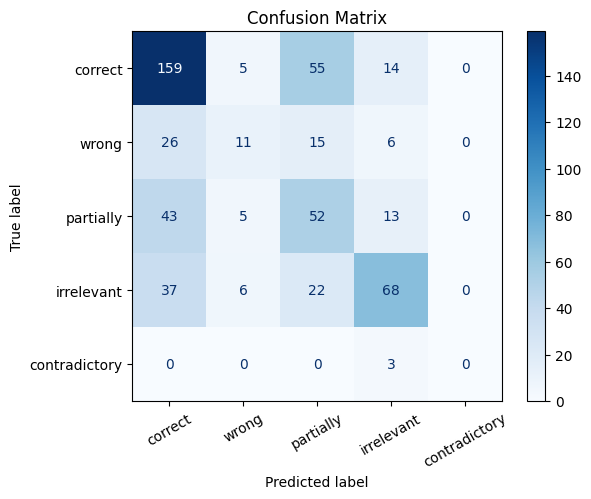

               precision    recall  f1-score   support

      correct       0.60      0.68      0.64       233
        wrong       0.41      0.19      0.26        58
    partially       0.36      0.46      0.40       113
   irrelevant       0.65      0.51      0.57       133
contradictory       0.00      0.00      0.00         3

     accuracy                           0.54       540
    macro avg       0.40      0.37      0.38       540
 weighted avg       0.54      0.54      0.53       540



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments

args = TrainingArguments(output_dir="./results", report_to="none")

trainer = Trainer(model=model, args=args)

preds = trainer.predict(encoded_test)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

labels = ["correct", "wrong", "partially", "irrelevant", "contradictory"]

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=30)
plt.title("Confusion Matrix")
plt.show()


print(classification_report(y_true, y_pred, target_names=labels))

# Analysis
The fine-tuned BERT-base model achieved an overall accuracy of 54% on the SciEntsBank test set.

Correct answers are recognized most reliably with F1 = 0.64, showing the model can capture well-formed scientific explanations.

Irrelevant responses also perform reasonably well with F1 = 0.57, with the model able to filter out off-topic answers.

Partially correct responses has F1 = 0.40, reflecting the difficulty of distinguishing nuanced misconceptions from complete answers.

Wrong responses show low recall with F1 = 0.26, meaning many incorrect answers are misclassified as other categories.

Contradictory answers could not be learned since it has F1 = 0.00. This might due to the extremely limited data like 3 examples.

From an educational perspective, the model demonstrates value in identifying students who have mastered concepts (correct) and those who are off-topic (irrelevant). However, it struggles with misconceptions, particularly distinguishing wrong, partially correct, and contradictory responses.

# Explainability
Since the wrong responses show low recall, we'd like to do more analysis on the category to identify more explainable reasons.

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [21]:
!pip install captum

import torch
from captum.attr import IntegratedGradients
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model.eval()

# Example
question = "What do plants use for photosynthesis?"
student_answer = "Plants eat soil"

inputs = tokenizer(
    question,
    student_answer,
    return_tensors="pt",
    truncation=True,
    padding=True
)

input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# embeddings from model
embeddings = model.get_input_embeddings()(input_ids)

def forward_func(embeddings):
    outputs = model(
        inputs_embeds=embeddings,
        attention_mask=attention_mask
    )
    return outputs.logits

# Run Integrated Gradients on embeddings
ig = IntegratedGradients(forward_func)
attributions, delta = ig.attribute(
    embeddings,
    target=0,   # explain why model label this answer as correct (0)
    return_convergence_delta=True
)

print("Attributions shape:", attributions.shape)



Attributions shape: torch.Size([1, 15, 768])


In [22]:
import torch
token_attributions = attributions.mean(dim=-1).squeeze(0)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

for tok, score in zip(tokens, token_attributions):
    print(f"{tok:15s} {score.item():.4f}")


[CLS]           0.0001
what            -0.0000
do              0.0000
plants          -0.0000
use             0.0001
for             0.0001
photos          0.0001
##yn            0.0004
##thesis        0.0002
?               0.0003
[SEP]           0.0008
plants          0.0002
eat             0.0001
soil            0.0000
[SEP]           0.0025


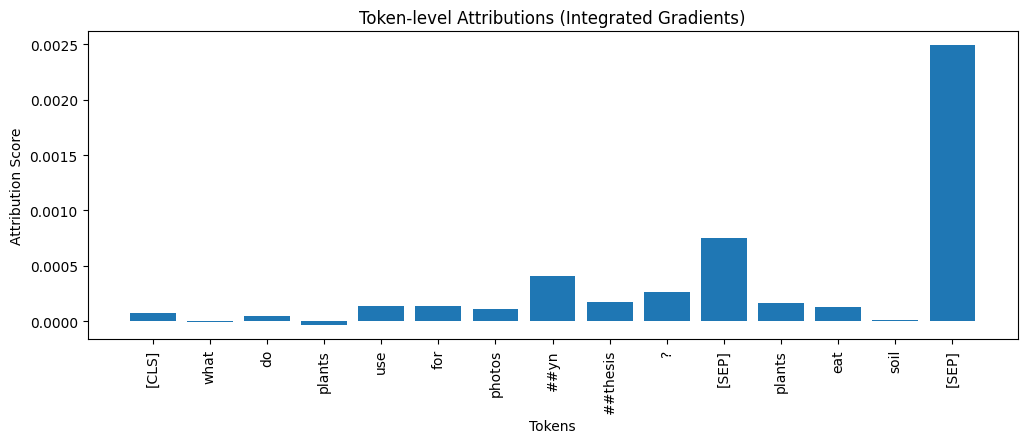

In [23]:
import matplotlib.pyplot as plt

token_attributions = attributions.mean(dim=-1).squeeze(0)  # [seq_len]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

scores = token_attributions.detach().numpy()

plt.figure(figsize=(12, 4))
plt.bar(range(len(tokens)), scores)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.title("Token-level Attributions (Integrated Gradients)")
plt.xlabel("Tokens")
plt.ylabel("Attribution Score")
plt.show()


The high attribution on [SEP] suggests that the model relies more on sentence boundaries than on meaningful content tokens when making predictions.

In [24]:
from IPython.display import HTML, display

def highlight_tokens(tokens, scores):
    norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-6)

    html_text = ""
    for tok, score in zip(tokens, norm_scores):
        # green -> positive effect
        color = f"rgba(0, 200, 0, {score})" if score > 0 else f"rgba(200, 0, 0, {-score})"
        html_text += f"<span style='background-color:{color}; padding:2px; margin:2px'>{tok}</span> "
    display(HTML(html_text))

highlight_tokens(tokens, scores)


Case Analysis:

Examined token-level attributions using Integrated Gradients to better understand how the model makes predictions. In the example below:

Question: What do plants use for photosynthesis?

Student Answer: Plants eat soil

True Label: Wrong

Predicted Label: Correct

The attribution visualization shows that structural tokens such as [SEP] receive relatively high weights, while the misconception-indicating words eat and soil receive much weaker contributions. This indicates that the model has not fully learned to associate common misconception phrases with the wrong label.

From an educational perspective, this explains why the model’s recall on the wrong category is low: it does not reliably capture the linguistic patterns of student misconceptions. This analysis highlights precisely where the model struggles. Such insights are valuable for guiding future improvements, such as augmenting the dataset with more examples of typical misconceptions or applying class rebalancing strategies.